# **Import library**

In [ ]:
import os
from glob import glob
import pandas as pd
import numpy as np
import random
import cv2
import shutil
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
 
from tensorflow.keras.applications import MobileNetV2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
 
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


# **Data** **collecting**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jithushaji","key":"14a5325c03bb921bed1ad1181ac323b4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.18G/5.20G [01:49<00:00, 54.7MB/s]
100% 5.20G/5.20G [01:49<00:00, 50.9MB/s]


In [ ]:
!unzip /content/skin-cancer-mnist-ham10000.zip -d /content/skin

Streaming output truncated to the last 5000 lines.
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: /content/skin/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: /content/skin/ham10000_images_part_2/IS

# **pre-processing data**

In [ ]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)

In [ ]:
df_data = pd.read_csv('/content/skin/HAM10000_metadata.csv')
df = df_data.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]
df.reset_index(inplace=True)


def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df = df_data[df_data['duplicates'] == 'no_duplicates']
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']

df_data.set_index('image_id', inplace=True)

storing data to train & validation folders

In [ ]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('/content/skin/ham10000_images_part_1')
folder_2 = os.listdir('/content/skin/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/skin/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/skin/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/skin/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/skin/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [ ]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))


5954
1074
1024
484
301
131
109


# **data augmentation**

In [ ]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 6000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [ ]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))


5954
5920
5920
5858
5217
5290
4410


# **loading train & test data**

In [ ]:
train_path = '/content/base_dir/train_dir'
valid_path = '/content/base_dir/val_dir'

batch_size = 10
pic_size = 224

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_batches= datagen_train.flow_from_directory(train_path,
                                                    target_size=(pic_size,pic_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

valid_batches = datagen_validation.flow_from_directory(valid_path,
                                                    target_size=(pic_size,pic_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


# **Tuning model**





In [ ]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.densenet import DenseNet201
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
pre_trained_model = DenseNet201(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

74842112/74836368 [==============================] - 0s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
zero_padding2d
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_1
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3_b

In [ ]:
last_layer = pre_trained_model.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 1920)


In [ ]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 198, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 128, 64)  9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 96, 128, 64)  256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [ ]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 198, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 128, 64)  9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 96, 128, 64)  256         conv1/conv[0][0]                 
_______________________________________________________________________________________

# **Training**

In [24]:
history = model.fit_generator(train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=20,
            verbose=1,callbacks=[learning_rate_reduction])

3857/3857 [==============================] - 521s 135ms/step - loss: 0.1334 - acc: 0.9532 - val_loss: 1.0967 - val_acc: 0.7473
Epoch 8/20
3857/3857 [==============================] - 520s 135ms/step - loss: 0.1163 - acc: 0.9605 - val_loss: 0.3346 - val_acc: 0.9083
Epoch 9/20
3857/3857 [==============================] - 522s 135ms/step - loss: 0.0999 - acc: 0.9667 - val_loss: 0.2915 - val_acc: 0.9211
Epoch 10/20
Epoch 10/20
3857/3857 [==============================] - 520s 135ms/step - loss: 0.0935 - acc: 0.9678 - val_loss: 0.4000 - val_acc: 0.9158
Epoch 11/20
3857/3857 [==============================] - 520s 135ms/step - loss: 0.0798 - acc: 0.9747 - val_loss: 0.4292 - val_acc: 0.8870
Epoch 12/20
3857/3857 [==============================] - ETA: 0s - loss: 0.0781 - acc: 0.9749
Epoch 00012: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
3857/3857 [==============================] - 518s 134ms/step - loss: 0.0781 - acc: 0.9749 - val_loss: 0.4047 - val_acc: 0.9094

Epoch

# **Saving Model & Weights**

In [ ]:
model_json = model.to_json()
with open("SkinCancer_DenseNET201.json", "w") as json_file:
    json_file.write(model_json)

In [26]:
print("[INFO] saving mask detector model...")
model.save("SkinCancer_DenseNET201.h5", save_format="h5")

[INFO] saving mask detector model...
[INFO] saving mask detector model...


# **get labels**

In [32]:
label_map = (train_batches.class_indices)

In [33]:
print(label_map)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [66]:
y_prob = model.predict(train_batches) 

In [47]:
y_classes = y_prob.argmax(axis=-1)

In [ ]:
print(y_classes)

# **Confusion matrix**

In [62]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [67]:
cm = confusion_matrix(y_true=train_batches.classes, y_pred=np.argmax(y_prob, axis=-1))

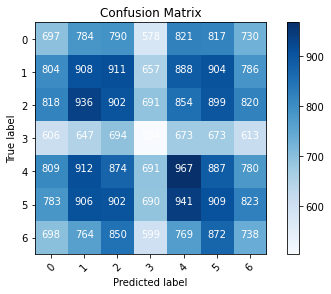

In [68]:
plot_confusion_matrix(cm=cm, classes=range(7), title='Confusion Matrix')